In [15]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

# Set visualization style
sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (12, 8)

In [16]:
# Load data
df = pd.read_csv("city_day.csv")

# Basic info
print("Dataset Info:")
print(df.info())

# Preview
print("\nFirst 5 rows:")
print(df.head())


# Basic statistics
print("\nDescriptive Statistics:")
print(df.describe(include="all"))

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB
None

First 5 rows:
        City        Date  PM2.5  PM10     NO    NO2    NOx  NH3   

In [17]:
# Create working copy
df_clean = df.copy()

# Identify target - AQI is continuous target variable
target = "AQI"

# Remove redundant columns (non-numeric and identifiers)
df_clean = df_clean.drop(["City", "Date", "AQI_Bucket"], axis=1, errors="ignore")

# Handle missing data
# 1. Impute numerical columns with median
num_cols = df_clean.select_dtypes(include=np.number).columns
imputer = SimpleImputer(strategy="median")
df_clean[num_cols] = imputer.fit_transform(df_clean[num_cols])

# 2. Drop rows where target is missing
df_clean = df_clean.dropna(subset=[target])

print(f"\nFinal dataset shape: {df_clean.shape}")


Final dataset shape: (29531, 13)


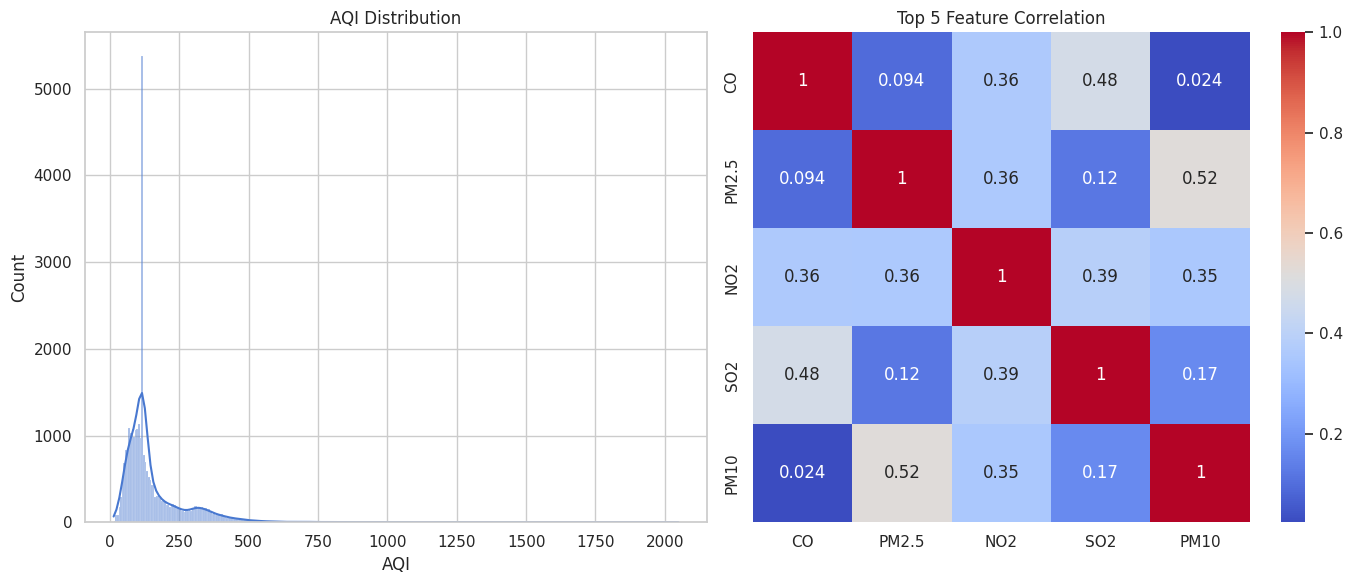

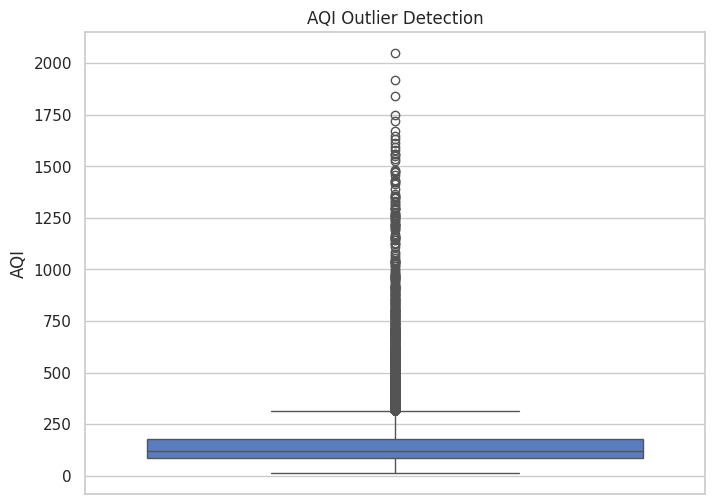

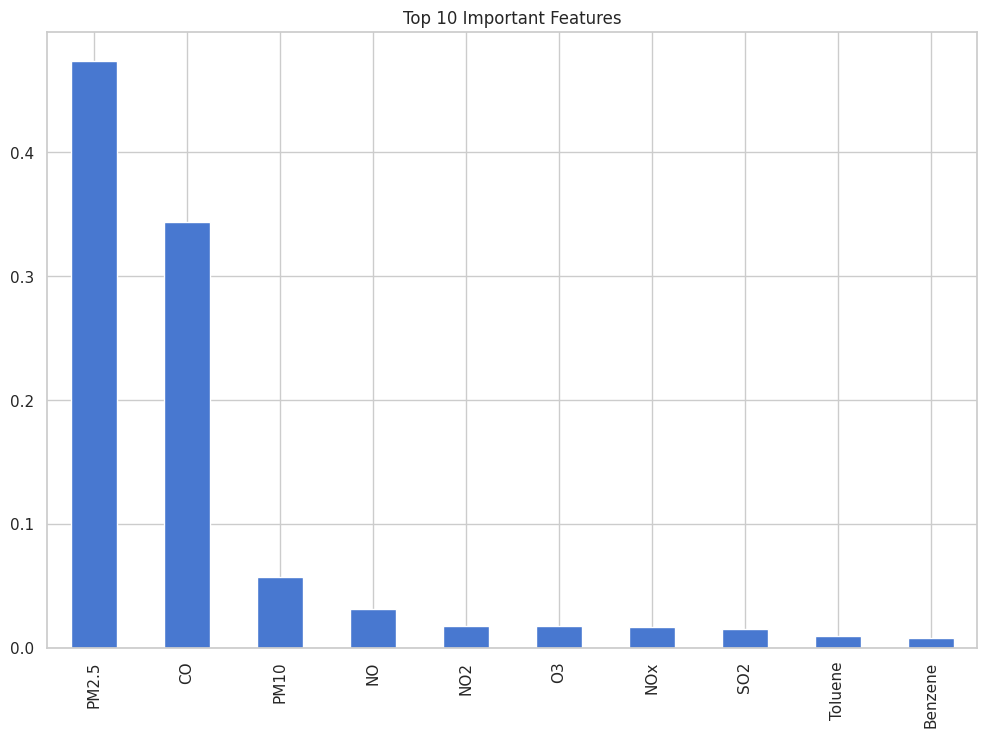

In [18]:
# 1. Target distribution
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_clean[target], kde=True)
plt.title("AQI Distribution")

# 2. Correlation heatmap (top 5 features)
corr_matrix = df_clean.corr().abs()
top_features = corr_matrix[target].sort_values(ascending=False).index[1:6]

plt.subplot(1, 2, 2)
sns.heatmap(df_clean[top_features].corr(), annot=True, cmap="coolwarm")
plt.title("Top 5 Feature Correlation")
plt.tight_layout()
plt.show()

# 3. Boxplot for target
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_clean[target])
plt.title("AQI Outlier Detection")
plt.show()

# 4. Feature importance preview
feature_imp = pd.Series(
    RandomForestRegressor().fit(df_clean.drop(target, axis=1), df_clean[target]
).feature_importances_,
    index=df_clean.drop(target, axis=1).columns
).sort_values(ascending=False)[:10]

feature_imp.plot(kind="bar")
plt.title("Top 10 Important Features")
plt.show()

In [19]:
# Remove target outliers using IQR method
Q1 = df_clean[target].quantile(0.25)
Q3 = df_clean[target].quantile(0.75)
IQR = Q3 - Q1

df_final = df_clean[
    (df_clean[target] >= Q1 - 1.5*IQR) &
    (df_clean[target] <= Q3 + 1.5*IQR)
]

print(f"Data points removed: {len(df_clean) - len(df_final)}")

Data points removed: 3192


In [20]:
# Select features and target
X = df_final.drop(target, axis=1)
y = df_final[target]

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[name] = {
        "R2": r2_score(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred)
    }

In [ ]:
# Results dataframe
results_df = pd.DataFrame(results).T

# Metrics comparison
fig, axes = plt.subplots(3, 1, figsize=(12, 10))
metrics = ["R2", "RMSE", "MAE"]
for i, metric in enumerate(metrics):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=axes[i])
    axes[i].set_title(f"{metric} Comparison")
    axes[i].set_ylim(0, results_df[metric].max()*1.1)
plt.tight_layout()
plt.show()

# Actual vs Predicted plot for best model
best_model = results_df["R2"].idxmax()
y_pred_best = models[best_model].predict(X_test)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "--r")
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title(f"{best_model} Predictions vs Actual")
plt.show()

# Feature importance for tree-based models
for name in ["Random Forest", "Gradient Boosting"]:
    if hasattr(models[name], "feature_importances_"):
        importances = pd.Series(
            models[name].feature_importances_,
            index=X.columns
        ).sort_values(ascending=False)[:10]

        plt.figure(figsize=(10, 6))
        importances.plot(kind="bar")
        plt.title(f"{name} Feature Importances")
        plt.show()

In [ ]:
print("\nCross-Validation Results:")
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring="r2")
    cv_results[name] = {
        "Mean R2": np.mean(scores),
        "Std Dev": np.std(scores)
    }
    print(f"{name}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

In [ ]:
print("\nKey Insights:")
print("1. Top predictive features:", list(feature_imp.index[:3]))
print(f"2. Best model: {best_model} (R2: {results_df.loc[best_model]['R2']:.3f})")
print("3. Most significant pollutant correlations:")
print(corr_matrix[target].sort_values(ascending=False).head(4))

In [ ]:
# Generate sample prediction
sample = X_test[0].reshape(1, -1)
print("\nSample Prediction:")
print(f"Actual AQI: {y_test.iloc[0]:.1f}")
print(f"Predicted AQI: {models[best_model].predict(sample)[0]:.1f}")